# Demo: Model Usage
In this notebook, we will demonstrate how to load a model and evaluate it on the test set.

## 1. Setup

In [3]:
# Automatic reloading
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
####################
# Required Modules #
####################

# Generic/Built-in
import random
import sys 
import os

# Libs
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader

The cell below sets up the environment by adding the project’s root directory to the system path and changing the current working directory, enabling imports from the `/src` folder. **This cell should only be ran once per session.**

In [5]:
# Add the project root directory to the system path to enable imports from the '/src' folder.

# Get the project directory 
current_dir = os.path.abspath('') # Current '\notebooks' directory
project_dir = os.path.abspath(os.path.join(current_dir, '..')) # Move up one level to project root directory

# Add the project directory to sys.path
sys.path.append(project_dir)

# Move up to project directory
os.chdir(project_dir)
os.getcwd()

# Import custom modules
from src.data_preparation import *
from src.models import *
from src.train_eval import *
from src.utils import *

c:\Users\Ryan Lee\.conda\envs\term6\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Seeding
SEED = 42

# To be safe, seed all modules for full reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using CUDA
np.random.seed(SEED)
random.seed(SEED)

## 2. Load Data

You can ignore the hyperparameter values below. The github repository should contain the dataset objects in `dataset_cache` folder as `train_dataset.py`, `val_dataset.py`, `test_dataset.py`. While these are already provided in the repository, these are also generated by the `prepare_datasets` function during training (refer to `notebooks/model_training.ipynb`).

As long as `load_if_exists=True`, the `prepare_datasets` function will automatically load in the existing dataset objects.

In [7]:
train_dataset, val_dataset, test_dataset = prepare_datasets(
    save_dir="dataset_cache", # Loads in already existing dataset objects
    load_if_exists=True # Must be set to True
)

# other hyperparameters do not matter when loading in existing dataset objects

✅ HARDataset objects (train/val/test) loaded from dataset_cache
✅ Created train, validation, and test dataset objects.


In [8]:
test_dataloader = DataLoader(test_dataset, batch_size = 256, shuffle = True)

## 3. Load Model

Create the model in the cell below. There are 7 model architectures to choose from: `HarLSTM`, `HarGRU`, `HarBiLSTM`, `HarCNN`, `HarInceptionCNN`, `HarTransformer`, and `HarTransformerExperimental`.

For your convenience, the saved model parameters are from models using the default hyperparameters.

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [53]:
model = HarTransformerExperimental()

# Load model parameters
model_params_path = "models/HarTransformerExperimental/Best_F1.pth" # Specify path to `pth` file here
model.load_state_dict(torch.load(model_params_path))

model.to(device)

HarTransformerExperimental(
  (cnn_tokenizer): Sequential(
    (0): Conv1d(6, 32, kernel_size=(5,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): Sequential(
    (0): RoPETransformerEncoderLayer(
      (self_attn): RoPEMultiheadAttention(
        (qkv_proj): Linear(in_features=32, out_features=96, bias=True)
        (out_proj): Linear(in_features=32, out_features=32, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (rotary_emb): RotaryPositionalEmbeddings()
      )
      (linear1): Linear(in_features=32, out_features=128, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=128, out_features=32, bias=True

The training script (`notebooks/model_training.ipynb`) automatically evaluates the latest model parameters (last epoch) immediately after training. In the cell above, we instead load in the model parameters with the best F1 score during training.

In [54]:
# Get normalization statistics from training set (which model was trained on)
normalizer = Normalizer()
normalizer.fit(training_dataset=train_dataset)

# Evaluate model on test set
loss, micro_accuracy, macro_accuracy, f1, precision, recall, conf_matrix = evaluate_HAR70_model(model, test_dataloader, normalizer)
print(f"(Test) Loss: {loss:.4f}, Accuracy (micro): {micro_accuracy:.4f}, Accuracy (macro): {macro_accuracy:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

(Test) Loss: 0.3149, Accuracy (micro): 0.9167, Accuracy (macro): 0.6914, F1: 0.6689, Precision: 0.6953, Recall: 0.6914


We will save our results to the `/results_demo` directory (not `/results` - that is where the results from `model_training.ipynb` are stored).

In [55]:
# Create subdirectory to save metric histories and the plots to. 
base_dir = "results_demo"
os.makedirs(base_dir, exist_ok=True) # Creates base directory
save_dir = os.path.join(base_dir, type(model).__name__)
os.makedirs(save_dir, exist_ok=True) # Create subdirectory

The `process_confusion_matrix` helper function below takes in the confusion matrix (unnormalized) and does the following:
- Saves the confusion matrix (numpy array) as a `npy` file. This can be loaded back in with `np.load`. 
- Recomputes the metrics (accuracy, f1, etc.) from the matrix and saves it as a  `txt` file.
    - The function returns the computed metrics.
- Plots the confusion matrix and saves it as `png` file.
- Normalizes the confusion matrix, then plots and saves it as `png` file.

✅ Confusion Matrix saved to: results_demo\HarTransformerExperimental\conf_matrix_12labels.npy
✅ Confusion Matrix Metrics saved to: results_demo\HarTransformerExperimental\conf_matrix_12labels_metrics.txt


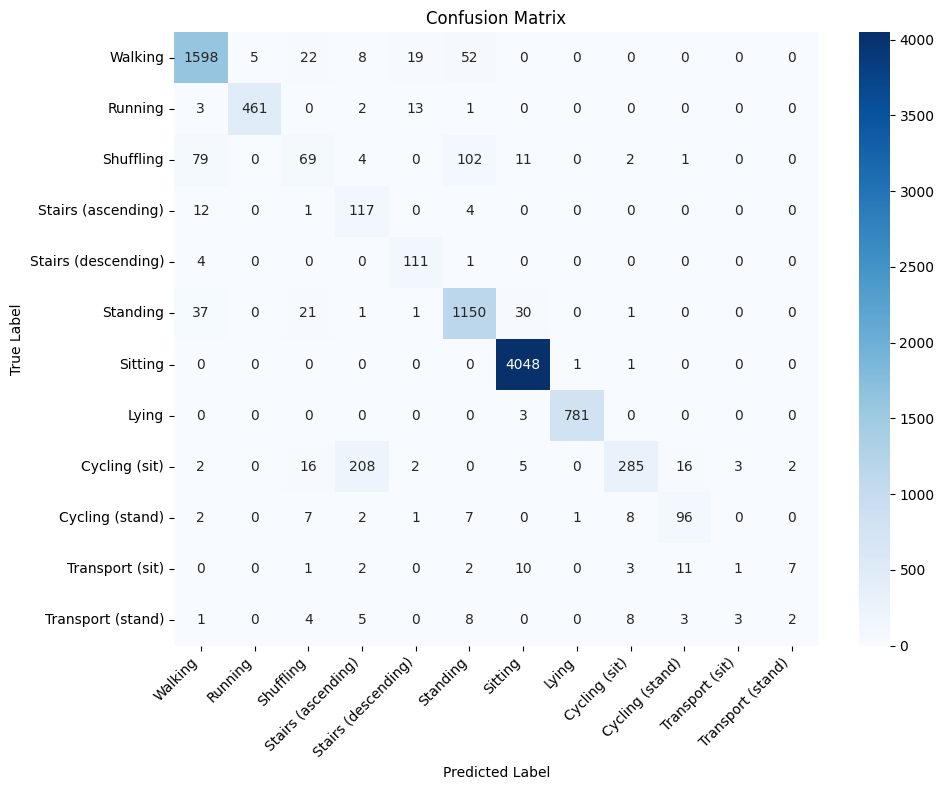

✅ Confusion Matrix Visualization saved to: results_demo\HarTransformerExperimental\conf_matrix_12labels.png


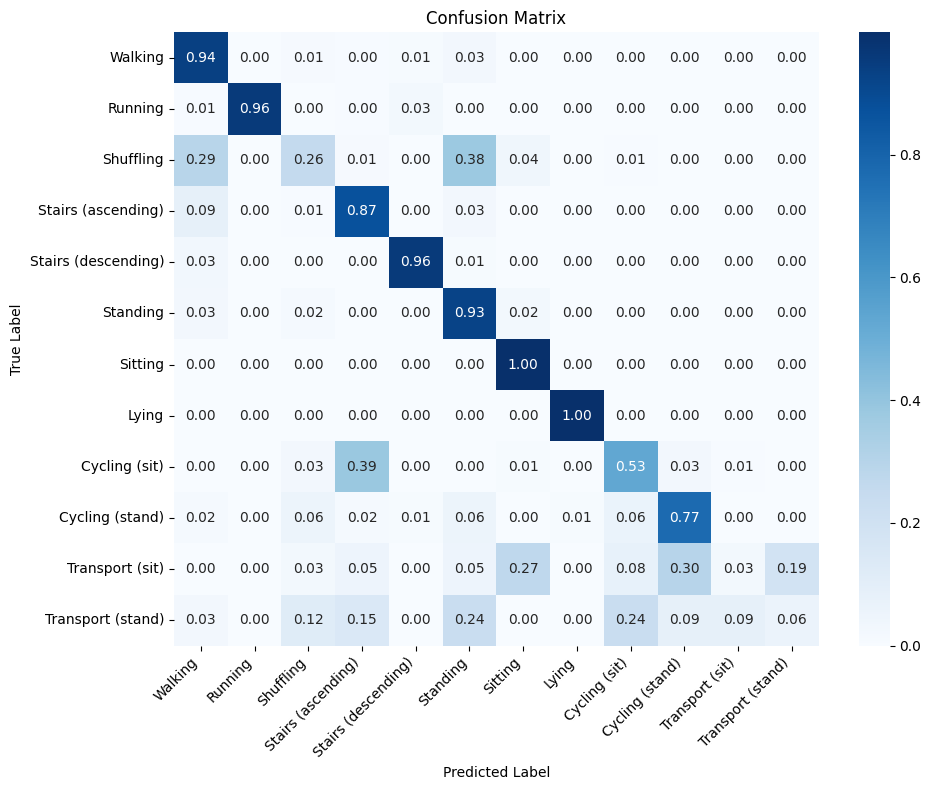

✅ Confusion Matrix Visualization saved to: results_demo\HarTransformerExperimental\conf_matrix_12labels_norm.png


{'micro_accuracy': 0.9167279991588687,
 'macro_accuracy': 0.6914047003005205,
 'precision': 0.6953356056287264,
 'recall': 0.6914047003005205,
 'f1': 0.6688636187518782}

In [56]:
file_name = "conf_matrix_12labels" # Base file name

# `class_names` is a list of label values
class_names = [
    "Walking", # Label 0
    "Running",
    "Shuffling",
    "Stairs (ascending)",
    "Stairs (descending)",
    "Standing",
    "Sitting",
    "Lying",
    "Cycling (sit)",
    "Cycling (stand)",
    "Transport (sit)",
    "Transport (stand)" # Label 11
] # Original label mapping (12)

metric_results = process_confusion_matrix(
    save_dir=save_dir,
    class_names=class_names,
    conf_matrix=conf_matrix,
    file_name=file_name
)
metric_results

For further analysis, we can **merge/ignore classes** in the confusion matrix as it was done in the original dataset papers. This is because some labels involve a very similar physical activity even though they have a different label.
We follow the exact same merges done in the HARTH paper:
- Shuffling, transport (standing), and standing are fused to the same physical activity "standing".
- Sitting and transport (sitting) are merged into "sitting".

Merging involves summing up the corresponding columns and rows in the summed confusion matrix, respectively, resulting in nine activity labels.

In [57]:
# Original class labels
list(enumerate(class_names))

[(0, 'Walking'),
 (1, 'Running'),
 (2, 'Shuffling'),
 (3, 'Stairs (ascending)'),
 (4, 'Stairs (descending)'),
 (5, 'Standing'),
 (6, 'Sitting'),
 (7, 'Lying'),
 (8, 'Cycling (sit)'),
 (9, 'Cycling (stand)'),
 (10, 'Transport (sit)'),
 (11, 'Transport (stand)')]

In [58]:
# Merge the following labels
merge_groups = [
    [2, 5, 11], # Shuffling + Standing + Transport (stand) 
    [6, 10], # Sitting (stand) + Transport (sit)
]
merge_names = [
    "Standing*",
    "Sitting*"
]

updated_conf_matrix, updated_class_names = merge_multiple_classes(
    conf_matrix=conf_matrix,
    class_names=class_names,
    merge_groups=merge_groups,
    merge_names=merge_names
)
list(enumerate(updated_class_names))

[(0, 'Standing*'),
 (1, 'Sitting*'),
 (2, 'Walking'),
 (3, 'Running'),
 (4, 'Stairs (ascending)'),
 (5, 'Stairs (descending)'),
 (6, 'Lying'),
 (7, 'Cycling (sit)'),
 (8, 'Cycling (stand)')]

✅ Confusion Matrix saved to: results_demo\HarTransformerExperimental\conf_matrix_9labels.npy
✅ Confusion Matrix Metrics saved to: results_demo\HarTransformerExperimental\conf_matrix_9labels_metrics.txt


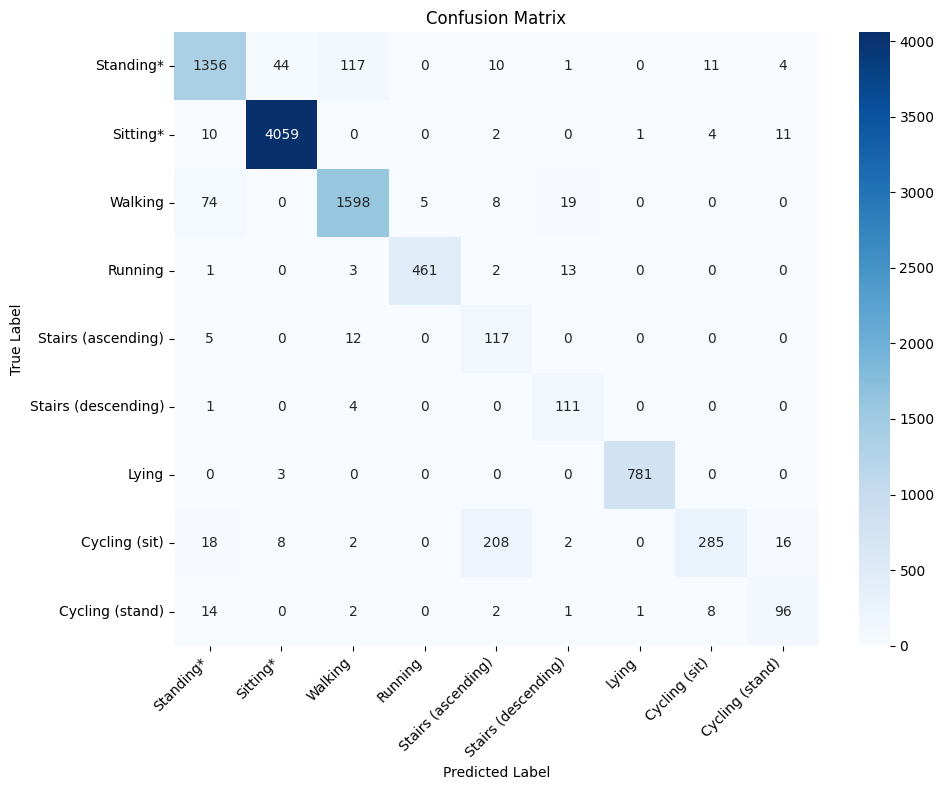

✅ Confusion Matrix Visualization saved to: results_demo\HarTransformerExperimental\conf_matrix_9labels.png


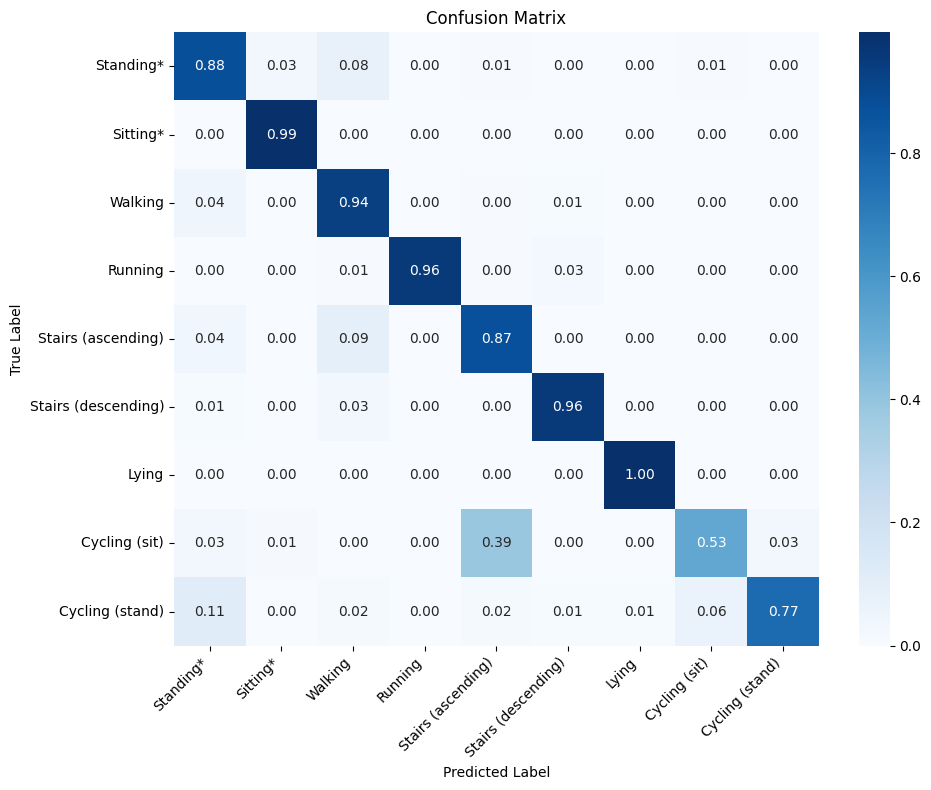

✅ Confusion Matrix Visualization saved to: results_demo\HarTransformerExperimental\conf_matrix_9labels_norm.png


{'micro_accuracy': 0.9319735043633687,
 'macro_accuracy': 0.8777023862175353,
 'precision': 0.8423562495129931,
 'recall': 0.8777023862175353,
 'f1': 0.8393054998736269}

In [59]:
file_name = "conf_matrix_9labels"
metric_results = process_confusion_matrix(
    save_dir=save_dir,
    class_names=updated_class_names, # Updated class names (merged)
    conf_matrix=updated_conf_matrix, # Updated confusion matrix (merged)
    file_name=file_name
)
metric_results